In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
def hess_to_tensor(H):
    hess_elements = []
    for i in range(len(H)):
        for j in range(len(H)):
            hess_elements.append(H[i][j].reshape(1))
    return torch.cat(hess_elements).reshape(len(H),len(H))

In [3]:
class Net(nn.Module):
    def __init__(self, n_features=7, nodes=[7,7], output_nodes=7,temp=0.0001):
        super(Net, self).__init__()
        self.temperature = temp
        # Build network
        n_nodes = [n_features] + nodes + [output_nodes]
        self.layers = nn.ModuleList()
        for i in range(len(n_nodes) - 1):
            linear_layer = nn.Linear(n_nodes[i], n_nodes[i+1])

            with torch.no_grad():
                linear_layer.weight.copy_(torch.eye(n_nodes[i+1], n_nodes[i]))
            with torch.no_grad():
                linear_layer.bias.zero_()
            self.layers.append(linear_layer)
            
            self.layers.append(nn.ReLU())
        
        
    # def _init_weights(self, module):
    #     if isinstance(module, nn.Linear):
    #         module.weight.data.copy_(torch.eye(7))
    #         if module.bias is not None:
    #             module.bias.data.zero_()
    #     print('INITIALED')


    def forward(self, x):
        out = self.layers[0](x)
        for layer in self.layers[1:]:
            out = layer(out)
        return out
        # out = out / self.temperature
        # return torch.softmax(out, dim=1)
        
    def set_temperature(self, temp):
        self.temperature = temp


In [4]:
filecode = 'InfA_RD_DPrmvd'
oc = np.load(f'/vols/cms/hw423/Data/Week14/octest_{filecode}.npy')
Lb = pd.read_pickle('/vols/cms/hw423/Data/Week14/Label.pkl')
dfy = pd.get_dummies(Lb)
dfw = pd.read_pickle('/vols/cms/hw423/Data/Week14/weight.pkl')
true = torch.tensor(np.array(dfy).astype(int))
labels = torch.tensor(np.array(Lb))
OC = torch.tensor(oc)
weight = torch.tensor(np.array(dfw))

In [5]:
labels = torch.tensor(np.array(Lb))
OC = torch.tensor(oc)
weight = torch.tensor(np.array(dfw))

In [6]:
model = Net()

In [7]:
model(OC)

tensor([[8.7100e-05, 7.8175e-01, 1.2887e-04,  ..., 1.9565e-01, 8.7100e-05,
         8.7100e-05],
        [1.1084e-02, 1.1598e-01, 2.5034e-01,  ..., 6.3189e-02, 3.5022e-01,
         1.9810e-01],
        [5.3004e-03, 3.0203e-01, 4.8681e-01,  ..., 1.6075e-01, 5.3004e-03,
         5.7316e-03],
        ...,
        [2.9180e-03, 4.4153e-01, 3.2937e-01,  ..., 1.9386e-01, 2.9180e-03,
         4.1305e-03],
        [3.6110e-05, 3.0695e-04, 3.6110e-05,  ..., 2.4619e-02, 3.9593e-05,
         1.0144e-04],
        [2.4696e-03, 1.0350e-01, 7.7559e-01,  ..., 9.2150e-02, 2.4696e-03,
         3.4909e-03]], grad_fn=<ReluBackward0>)

In [644]:
def test(x,n1,n2,label,model,weight):
    y = torch.argmax(model(x[label==1]),axis=1)
    # y = torch.argmax(x,axis=1)[label==1]
    n1=torch.tensor(n1,requires_grad=True)
    n2=torch.tensor(n2,requires_grad=True)
    print(y)
    def NLL(n1,n2,y):
        n0 = torch.tensor(1.0).view(-1)
        # N = torch.cat([n0,n])
        return n1**2*n2*n0*torch.sum(y**2)
    
    hess = torch.func.hessian(NLL,(0,1))(n1,n2,y)
    return torch.trace(hess_to_tensor(hess))

In [663]:
def test(x,n,label,model,weight):
    # y = torch.argmax(model(x[label==1]),axis=1)
    n0 = torch.tensor(1.0).view(-1)
    N = torch.cat([n0,n.view(-1)])
    print(N)
    def NLL(x,n,label,model,weight):
        outcome = model(x)
        weight = weight*13800
        pred = torch.argmax(outcome,dim=1)
        cm = torch.ones(7,7)
        # up = pred.unique()
        # ul = label.unique()
        # for p in up:
        #     for l in ul:
        #         cm[p,l] = torch.sum(weight[pred==p][label[pred==p]==l])
        cm =cm[1:, :]
        return (cm.sum(dim=0)*torch.sum(n**2)).sum()*outcome()
    hess = torch.func.hessian(NLL,(1))(x,N,label,model,weight)
    return torch.trace(hess_to_tensor(hess))

In [664]:
model = Net()
# n = torch.tensor([1.0,1.0,1.0,1.0,1.0,1.0],requires_grad=True)
n1 = torch.tensor([1.0])
n2 = torch.tensor([1.0])
model.train()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
optimiser.zero_grad()
test_y = test(OC,n1,labels,model,weight)
test_y.backward()
test_y

tensor([1., 1.])


: 

In [648]:
print(n2.grad)
for name, param in model.named_parameters():
    print(f"梯度 {name}: {param.grad}")

None
梯度 layers.0.weight: None
梯度 layers.0.bias: None
梯度 layers.2.weight: None
梯度 layers.2.bias: None
梯度 layers.4.weight: None
梯度 layers.4.bias: None


In [162]:
torch.cat([input[0].view(-1),input[1].view(-1)],dim=0)

tensor([1., 1.], grad_fn=<CatBackward0>)

In [283]:
def test(x,n,label):
    # y = torch.argmax(model(x[label==1]),axis=1)
    y = torch.argmax(x,axis=1)[label==1]
    
    print(y)
    def NLL(nn,y):
        n = nn.view(-1)
        n0 = torch.tensor(1.0).view(-1)
        N = torch.cat([n0,n])
        return N[1]**2*N[2]*N[0]*torch.sum(y**2)
    hess = torch.func.hessian(NLL,(0))(n,y)
    print(hess)
    return torch.trace(hess_to_tensor(hess))

In [41]:
def smooth_argmax(tensor, dim=-1, temperature=1.0):
    softmax_tensor =F.softmax(tensor / temperature, dim=dim)
    return softmax_tensor
def confusion_matrix(OC,label,weight,model):
    label_w = weight.unsqueeze(1)*label
    pred_matrix = smooth_argmax(model(OC),temperature=.01,dim=1)
    confusion_matrix = torch.matmul(pred_matrix.t(),label_w)[:,1:]
    return confusion_matrix.t()

def NLL(mu1,mu2,mu3,mu4,mu5,mu6,input,target,model,weight):
    cm = confusion_matrix(input,target,weight,model)
    O = torch.sum(cm,dim=1)
    mu1 = mu1.view(-1)
    mu2 = mu2.view(-1)
    mu3 = mu3.view(-1)
    mu4 = mu4.view(-1)
    mu5 = mu5.view(-1)
    mu6 = mu6.view(-1)
    mu0 =torch.tensor([1.0]).view(-1)
    theta = torch.cat([mu0,mu1,mu2,mu3,mu4,mu5,mu6])
    return -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))

def InfAwareLoss(input,target,weight,model,mu_init):

    mu1 = torch.tensor(mu_init['mu1'], requires_grad=True)
    mu2 = torch.tensor(mu_init['mu2'], requires_grad=True)
    mu3 = torch.tensor(mu_init['mu3'], requires_grad=True)
    mu4 = torch.tensor(mu_init['mu4'], requires_grad=True)
    mu5 = torch.tensor(mu_init['mu5'], requires_grad=True)
    mu6 = torch.tensor(mu_init['mu6'], requires_grad=True)

    hess = torch.func.hessian(NLL,(0,1,2,3,4,5))(mu1,mu2,mu3,mu4,mu5,mu6,input,target,model,weight)
    H = hess_to_tensor(hess)
    I = -torch.inverse(H)
    loss = torch.trace(I**0.5)
    
    return loss


In [32]:
def NLL(mu1,mu2,mu3,mu4,mu5,mu6,input,target,model,weight):
    outcome = model(input)
    # input = torch.tensor(input).view(-1)
    # label =label.view(-1)
  
    label = torch.argmax(target,dim=1)
    pred = torch.argmax(outcome,dim=1)
    cm = torch.zeros(7,7)
    up = pred.unique()
    ul = label.unique()
    for p in up:
        for l in ul:
            cm[p,l] = torch.sum(weight[pred==p][label[pred==p]==l]*138000)
    cm =cm[1:, :]
    O = torch.sum(cm,dim=1)
    mu1 = mu1.view(-1)
    mu2 = mu2.view(-1)
    mu3 = mu3.view(-1)
    mu4 = mu4.view(-1)
    mu5 = mu5.view(-1)
    mu6 = mu6.view(-1)
    mu0 =torch.tensor([1.0]).view(-1)
    theta = torch.cat([mu0,mu1,mu2,mu3,mu4,mu5,mu6])
    return -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))

def InfAwareLoss(input,target,weight,model,mu_init):

    mu1 = torch.tensor(mu_init['mu1'], requires_grad=True)
    mu2 = torch.tensor(mu_init['mu2'], requires_grad=True)
    mu3 = torch.tensor(mu_init['mu3'], requires_grad=True)
    mu4 = torch.tensor(mu_init['mu4'], requires_grad=True)
    mu5 = torch.tensor(mu_init['mu5'], requires_grad=True)
    mu6 = torch.tensor(mu_init['mu6'], requires_grad=True)
    

    hess = torch.func.hessian(NLL,(0,1,2,3,4,5))(mu1,mu2,mu3,mu4,mu5,mu6,input,target,model,weight)
    H = hess_to_tensor(hess)
    I = torch.inverse(H)
    loss = torch.trace(I)
    
    return loss


In [47]:
label = torch.tensor(np.array(dfy),dtype = torch.float32)
def confusion_matrix(OC,label,weight,model):
    label_w = 138000*weight.unsqueeze(1)*label
    pred_matrix = smooth_argmax(model(OC),temperature=.01,dim=1)
    # pred_matrix_w = weight.unsqueeze(1)*pred_matrix
    confusion_matrix = torch.matmul(pred_matrix.t(),label_w)[1:,:]
    return confusion_matrix


In [48]:
def NLL(theta,label,weight,model):
    cm = confusion_matrix(OC,label,weight,model)
    O = torch.sum(cm,dim=1)
    return -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))

In [49]:
model = Net()
theta = torch.ones(7)
hess = torch.func.hessian(NLL,0)(theta,label,weight,model)
H = hess_to_tensor(hess)
I = torch.inverse(H)
torch.trace(I)

: 

In [63]:
# label = torch.argmax(labels,dim=1)
pred = torch.argmax(OC,dim=1)
cm = torch.zeros(7,7)
up = pred.unique()
ul = labels.unique()
for p in up:
    for l in ul:
        cm[p,l] = torch.sum(weight[pred==p][labels[pred==p]==l]*138000)
# cm =cm[1:, :]
# O = torch.sum(cm,dim=1)
# theta = torch.ones(7)
# -(O@(torch.log(cm@theta))-torch.sum((cm@theta)))


In [72]:
cm[1:,:]

tensor([[5.2990e+04, 3.7661e+03, 1.5567e+02, 7.0351e+00, 6.1755e+00, 9.1034e-02,
         2.0884e-01],
        [9.1670e+03, 6.4205e+02, 2.6407e+02, 1.8908e+00, 1.2122e+00, 4.0618e-01,
         9.7135e-01],
        [1.4701e+03, 4.9133e+01, 1.4440e+01, 2.1173e+01, 2.2345e+00, 1.9410e+00,
         8.9976e-01],
        [4.5219e+03, 2.6751e+02, 3.6474e+01, 6.1455e+00, 9.1902e+00, 8.4212e-01,
         3.6518e-01],
        [3.6574e+03, 9.2775e+01, 2.1335e+01, 1.8868e+00, 8.6143e-01, 4.5226e+01,
         4.2431e+00],
        [3.0145e+03, 2.2421e+02, 5.1616e+01, 1.5866e+00, 6.9564e-01, 9.2929e+00,
         4.6096e+00]])

In [132]:
cm_w = pd.DataFrame(confusion_matrix.t().detach().numpy())
CM = []
for i in range(6):
    cl = cm_w.iloc[:,i]/cm_w.iloc[:,i].sum()
    CM.append(cl)
cm = pd.DataFrame(CM).T


In [133]:
col = ['$\gamma\gamma$','ggH','qqH','WH','ZH','ttH','tH']
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues, filename='/vols/cms/hw423/Week14/plots/confusion_matrix_test.pdf'):
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap)  # Using '.2f' for floating point format
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    ax.set_xticklabels(col[1:])
    ax.set_yticklabels(col[1:])
    fig.savefig(filename, bbox_inches='tight')  

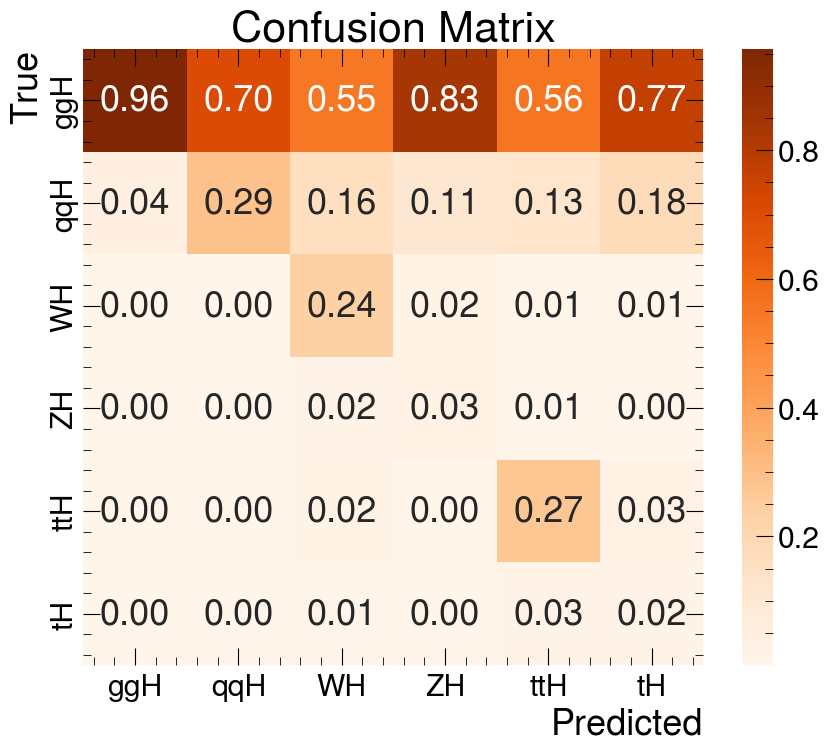

In [135]:

import mplhep as hep
hep.style.use("CMS")
plot_confusion_matrix(cm, cmap=plt.cm.Oranges,)

In [5]:
# filecode = 'InfA_RD_DPrmvd'
# oc = np.load(f'/vols/cms/hw423/Data/Week14/octest_{filecode}.npy')
# label = pd.read_pickle('/vols/cms/hw423/Data/Week14/Label.pkl')
# dfy = pd.get_dummies(label)
# dfw = pd.read_pickle('/vols/cms/hw423/Data/Week14/weight.pkl')
# true = torch.tensor(np.array(dfy).astype(int))

In [40]:
loss = InfAwareLoss(OC,true,weight,model,mu_ini)
loss

/tmp/ipykernel_781567/3867228192.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu1 = torch.tensor(mu_init['mu1'], requires_grad=True)
/tmp/ipykernel_781567/3867228192.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu2 = torch.tensor(mu_init['mu2'], requires_grad=True)
/tmp/ipykernel_781567/3867228192.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu3 = torch.tensor(mu_init['mu3'], requires_grad=True)
/tmp/ipykernel_781567/3867228192.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

tensor(nan, grad_fn=<TraceBackward0>)

In [39]:
model = Net()
model.train()
mu_ini_ex = {'mu1': 1.0, 'mu2': 1.0, 'mu3': 1.0, 'mu4': 1.0, 'mu5': 1.0, 'mu6': 1.0}
mu_ini = {key: torch.tensor(value,requires_grad=True) for key, value in mu_ini_ex.items()}
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
optimiser.zero_grad()
true = label

loss = InfAwareLoss(OC,true,weight,model,mu_ini)
loss.retain_grad
loss.backward()
for name, param in model.named_parameters():
    print(f"Gradient {name}: {param.grad}")
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

/tmp/ipykernel_781567/3867228192.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu1 = torch.tensor(mu_init['mu1'], requires_grad=True)
/tmp/ipykernel_781567/3867228192.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu2 = torch.tensor(mu_init['mu2'], requires_grad=True)
/tmp/ipykernel_781567/3867228192.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu3 = torch.tensor(mu_init['mu3'], requires_grad=True)
/tmp/ipykernel_781567/3867228192.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Gradient layers.0.weight: tensor([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan]])
Gradient layers.0.bias: tensor([nan, nan, nan, nan, nan, nan, nan])
Gradient layers.2.weight: tensor([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan]])
Gradient layers.2.bias: tensor([nan, nan, nan, nan, nan, nan, nan])
Gradient layers.4.weight: tensor([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, 

In [641]:
print(loss.grad)

None


/tmp/ipykernel_2100582/2657634666.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /croot/pytorch_1686931851744/work/build/aten/src/ATen/core/TensorBody.h:486.)
  print(loss.grad)


In [626]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

layers.0.weight: True
layers.0.bias: True
layers.2.weight: True
layers.2.bias: True
layers.4.weight: True
layers.4.bias: True


In [138]:
for name, param in mu_ini.items():
    if param.grad is not None:
        print(f'Gradient for {name}: {param.grad}')
    else:
        print(f'No gradient for {name}')

NameError: name 'mu_ini' is not defined